# Tutorial 1: 10x Visium human DLPFC dataset (recovery)
We performed recovery experiment on 151673 sample of the human dorsolateral prefrontal cortex (DLPFC) dataset. The white matter (WM) and six cortex layers have been manually annotated. We randomly down-sampled 50% of measured spots and recovered data on all of measured spots.

Here, we demonstrate how to recover down-sampled data on 10x Visium human DLPFC dataset by STAGE. The original data with the standard format of 10x Visium data can be downloaded from [Github](https://github.com/LieberInstitute/spatialLIBD). The manual annotation are available at the spatialLIBD package and we also provided them at [Google Drive](https://drive.google.com/drive/folders/1Gp-nr9c0YGJs1l4UPRAtlIDekmXAW9hS).

## Data preprocessing

In [1]:
import warnings
warnings.filterwarnings("ignore")
import STAGE
import scanpy as sc
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
from tqdm import tqdm

In [2]:
section_id = '151673'

In [3]:
input_dir = os.path.join('Data/T1', section_id)
adata = sc.read_visium(path=input_dir, count_file='filtered_feature_bc_matrix.h5')
adata.var_names_make_unique()

In [4]:
# Coordinates (array_col, array_row)
adata.obsm["coord"]=adata.obs.loc[:, ['array_col', 'array_row']].to_numpy()

In [5]:
# read the annotation
Ann_df = pd.read_csv(os.path.join('Data/T1', section_id, section_id+'_truth.txt'), sep='\t', header=None, index_col=0)
Ann_df.columns = ['Ground Truth']

In [6]:
# Labels (layer)
adata.obs['layer'] = Ann_df.loc[adata.obs_names, 'Ground Truth']
adata.uns['layer_colors']=['#1f77b4', '#ff7f0e', '#49b192', '#d62728', '#aa40fc', '#8c564b', '#e377c2'] 

[<AxesSubplot:title={'center':'Ground Truth'}, xlabel='spatial1', ylabel='spatial2'>]

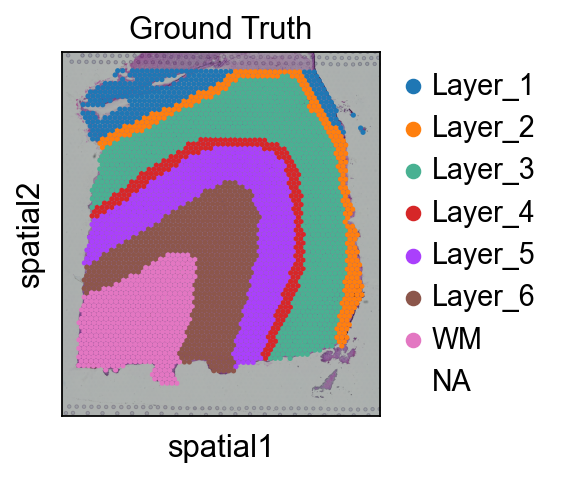

In [8]:
sc.set_figure_params(dpi=80, figsize=(3, 3))
sc.pl.spatial(adata, img_key="hires", color='layer', title='Ground Truth', size=1.5, show=False)

In [9]:
# Normalization
sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=5000)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

## Running model

In [10]:
# The parameter relu provides the choice of whether the output layers have ReLU activation function. 
# We recommended relu = True, you can also try relu = False. Both STAGE and the following VGE have this parameter. 
# If you want to run the model on the GPU, please specify the graphics card by the parameter device in advance, 
# and make sure your GPU is available, otherwise it will run on the CPU by default.
adata_sample, adata_stage = STAGE.STAGE(
    adata,
    save_path='./T1_STAGE',
    data_type='10x',
    experiment='recovery',
    down_ratio=0.5,
    coord_sf=77,
    train_epoch=10000,
    seed=1234,
    batch_size=512,
    learning_rate=1e-3,
    w_recon=0.1,
    w_w=0.1,
    w_l1=0.1,
    relu=True,
    device='cuda:0'
)

Epochs: 100%|██| 10000/10000 [1:19:59<00:00,  2.08it/s, latent_loss: 0.00301, recon_loss: 0.14267, total_loss: 0.01727]


In [11]:
adata_stage

AnnData object with n_obs × n_vars = 3639 × 5000
    obs: 'in_tissue', 'array_row', 'array_col', 'layer'
    obsm: 'coord'

## Genes spatial visualizaion

In [12]:
sc.set_figure_params(dpi=80, figsize=(2.8, 3))

In [13]:
# Flip the y-coordinates
adata.obsm['coord'][:,1] = adata.obsm['coord'][:,1]*(-1)

In [14]:
# Select marker genes
show_gene=["PCP4","FABP4"]

[<AxesSubplot:title={'center':'PCP4'}, xlabel='coord1', ylabel='coord2'>,
 <AxesSubplot:title={'center':'FABP4'}, xlabel='coord1', ylabel='coord2'>]

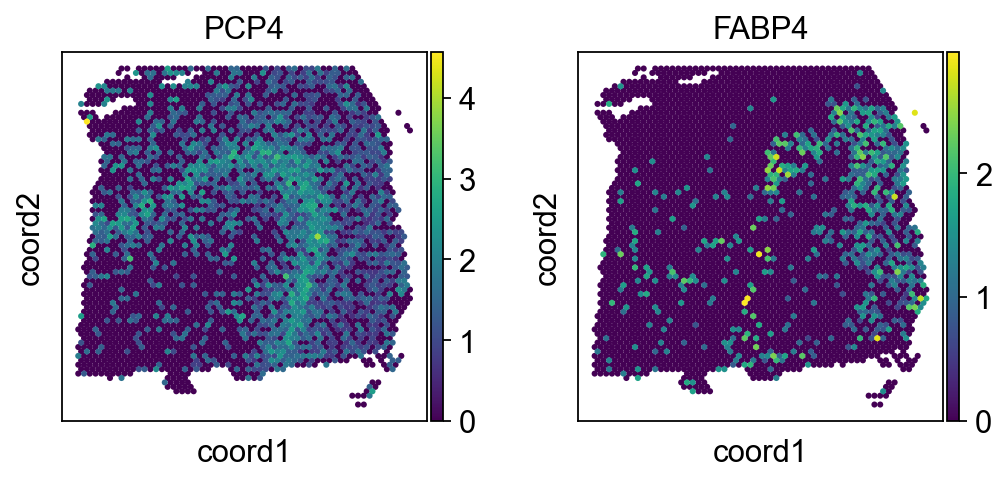

In [15]:
sc.pl.embedding(adata, basis="coord", color=show_gene, s=30, show=False)

[<AxesSubplot:title={'center':'PCP4'}, xlabel='coord1', ylabel='coord2'>,
 <AxesSubplot:title={'center':'FABP4'}, xlabel='coord1', ylabel='coord2'>]

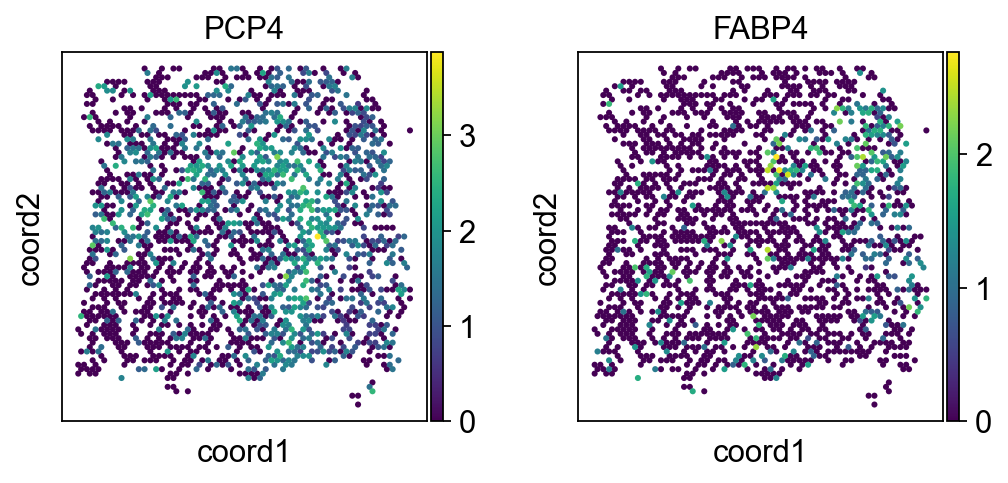

In [16]:
sc.pl.embedding(adata_sample, basis="coord", color=show_gene, s=30, show=False)

[<AxesSubplot:title={'center':'PCP4'}, xlabel='coord1', ylabel='coord2'>,
 <AxesSubplot:title={'center':'FABP4'}, xlabel='coord1', ylabel='coord2'>]

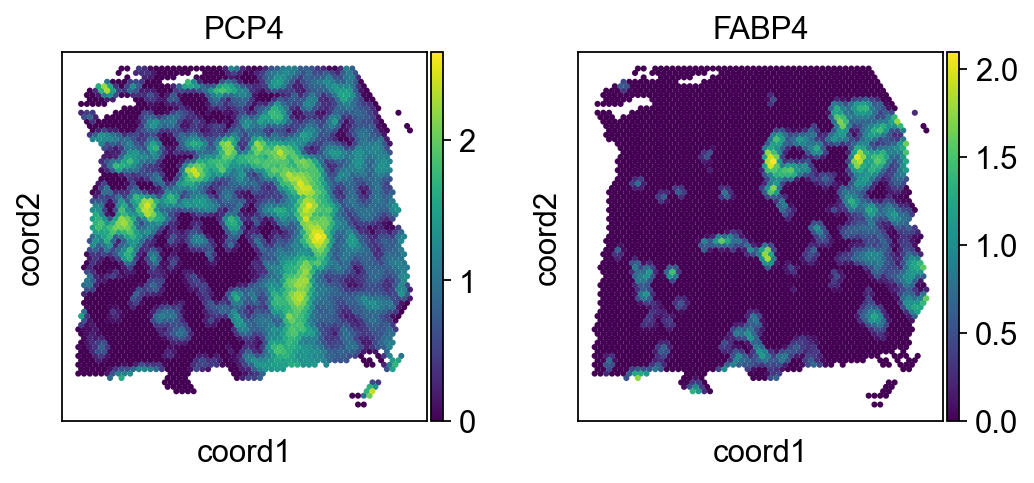

In [17]:
sc.pl.embedding(adata_stage, basis="coord", color=show_gene, s=30, show=False)

## Spatial trajectory inference (PAGA)

In [18]:
# Original data
sc.pp.pca(adata, n_comps=30)
sc.pp.neighbors(adata, use_rep='X_pca')
sc.tl.umap(adata)
used_adata = adata[adata.obs['layer'].isna()==False,]
sc.tl.paga(used_adata, groups='layer')

In [19]:
# Down-sampled data
sc.pp.pca(adata_sample, n_comps=30)
sc.pp.neighbors(adata_sample, use_rep='X_pca')
sc.tl.umap(adata_sample)
used_adata_sample = adata_sample[adata_sample.obs['layer'].isna()==False,]
sc.tl.paga(used_adata_sample, groups='layer')

In [20]:
# Recovered data
sc.pp.pca(adata_stage, n_comps=30)
sc.pp.neighbors(adata_stage, use_rep='X_pca')
sc.tl.umap(adata_stage)
used_adata_stage = adata_stage[adata_stage.obs['layer'].isna()==False,]
sc.tl.paga(used_adata_stage, groups='layer')

In [21]:
sc.set_figure_params(dpi=80, figsize=(4, 3))

[<Axes:xlabel='UMAP1', ylabel='UMAP2'>, <Axes:>]

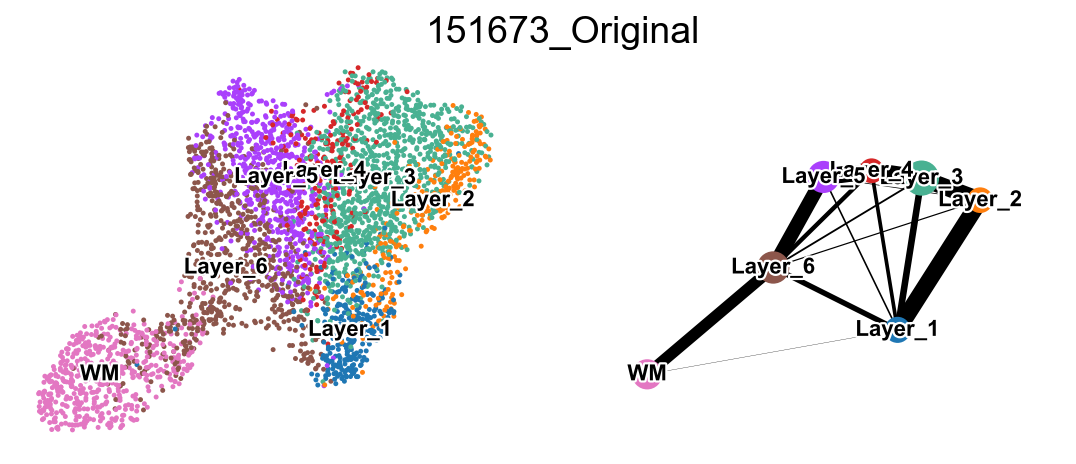

In [22]:
sc.pl.paga_compare(used_adata, legend_fontsize=10, frameon=False, size=20, 
                   title=section_id+'_Original', legend_fontoutline=2, show=False)

[<Axes:xlabel='UMAP1', ylabel='UMAP2'>, <Axes:>]

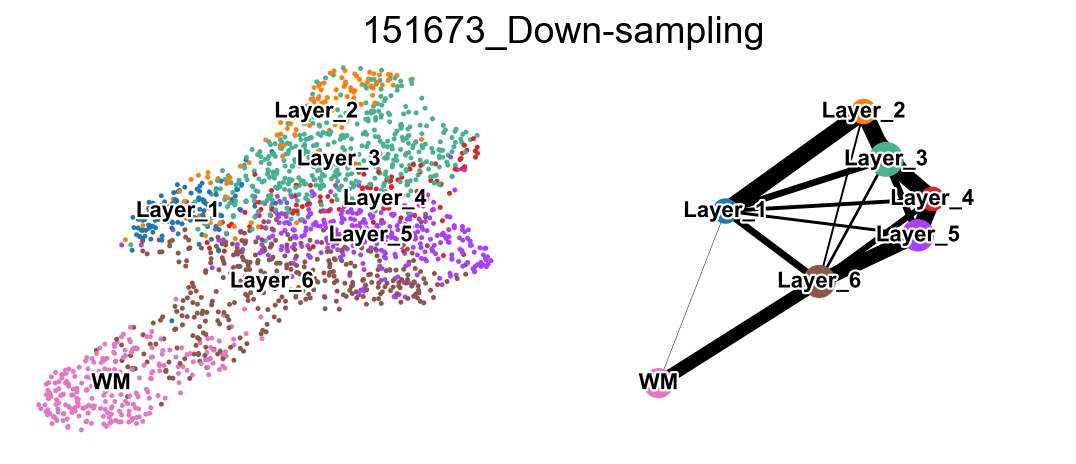

In [23]:
sc.pl.paga_compare(used_adata_sample, legend_fontsize=10, frameon=False, size=20, 
                   title=section_id+'_Down-sampling', legend_fontoutline=2, show=False)

[<Axes:xlabel='UMAP1', ylabel='UMAP2'>, <Axes:>]

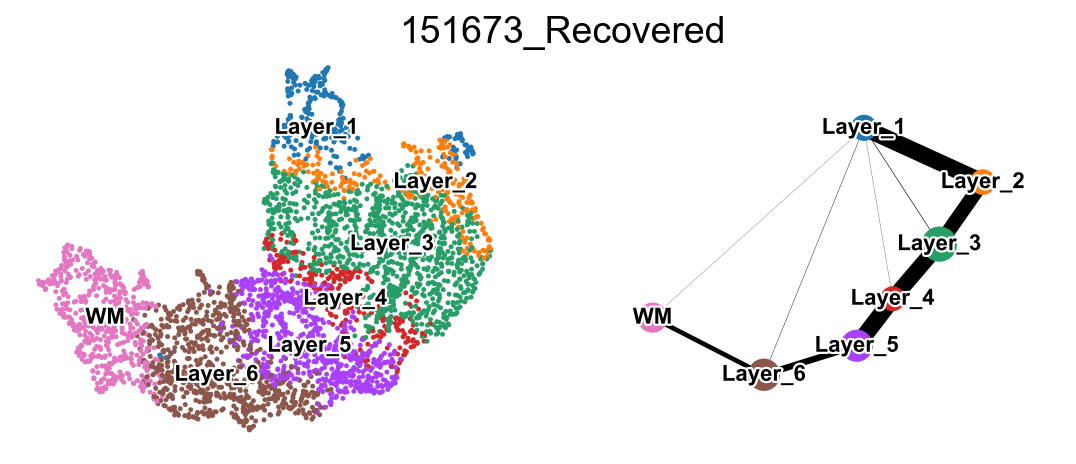

In [24]:
sc.pl.paga_compare(used_adata_stage, legend_fontsize=10, frameon=False, size=20, 
                   title=section_id+'_Recovered', legend_fontoutline=2, show=False)

## Ablation experiment

In [25]:
# Run vanilla generator
adata_sample, adata_vge = STAGE.VGE(
    adata,
    save_path='./T1_VGE',
    down_ratio=0.5,
    coord_sf=77,
    train_epoch=10000,
    seed=1234,
    batch_size=512,
    learning_rate=1e-3,
    w_recon=0.1,
    w_l1=0.1,
    relu=True,
    device='cuda:0'
)

Epochs: 100%|████████████████████████| 10000/10000 [1:10:02<00:00,  2.38it/s, recon_loss: 0.14184, total_loss: 0.01418]


In [26]:
adata_vge

AnnData object with n_obs × n_vars = 3639 × 5000
    obs: 'in_tissue', 'array_row', 'array_col', 'layer'
    obsm: 'coord'

In [27]:
pr_stage=np.zeros(shape=(adata_stage.shape[1]))
pr_vge=np.zeros(shape=(adata_stage.shape[1]))
used_gene=adata_stage.var.index

In [28]:
# Pearson correlation between the recovered data and the original data of each gene
for it in tqdm(range(adata_stage.shape[1])):
    pr_stage[it]=pearsonr(adata_stage[:,used_gene[it]].X.toarray().squeeze(),adata[:,used_gene[it]].X.toarray().squeeze())[0]
    pr_vge[it]=pearsonr(adata_vge[:,used_gene[it]].X.toarray().squeeze(),adata[:,used_gene[it]].X.toarray().squeeze())[0]

100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [01:58<00:00, 42.26it/s]


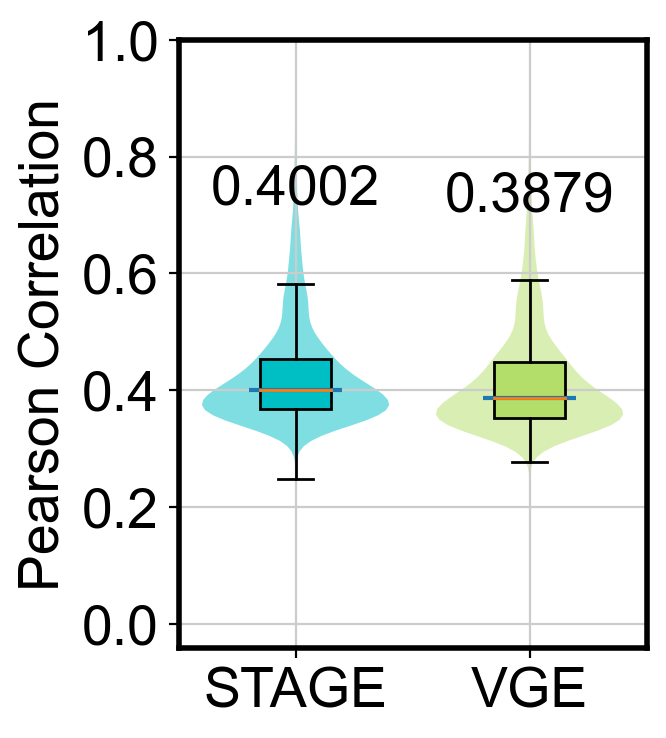

In [29]:
sc.set_figure_params(dpi=100, figsize=(3, 4))
common_non_nan = np.logical_and(~np.isnan(pr_stage), ~np.isnan(pr_vge))
pr_stage_common = pr_stage[common_non_nan]
pr_vge_common = pr_vge[common_non_nan]
distances = [pr_stage_common, pr_vge_common]
colors = ["#00BFC4", "#B3DE69"]
box_color = "grey"

fig, ax = plt.subplots()

boxplot = ax.boxplot(distances, sym='k+', showfliers=False, widths=0.3, patch_artist=True)
for i, box in enumerate(boxplot['boxes']):
    box.set_facecolor(colors[i])


violinplot = ax.violinplot(distances, showmedians=True, widths=0.8, showextrema=False)
for partname, part in violinplot.items():
    if partname == 'bodies':
        for pc, color in zip(part, colors):
            pc.set_alpha(0.5)
            pc.set_facecolor(color)
            
ax.set_ylim(top=1)
ax.set_xticks([1, 2])
ax.set_xticklabels(['STAGE', 'VGE'])
ax.set_ylabel('Pearson Correlation', fontsize=20)
plt.yticks([0,0.2,0.4,0.6,0.8,1])
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(2)
ytick_labels = plt.gca().get_yticklabels()
for label in ytick_labels:
    label.set_fontsize(20)
xtick_labels = plt.gca().get_xticklabels()
for label in xtick_labels:
    label.set_fontsize(20)
    
for median, label in zip(boxplot['medians'], ['STAGE', 'VGE']):
    median_value = median.get_ydata()[0]
    x_position = median.get_xdata()[0]  
    ax.text(x_position+0.15, median_value+0.3, f'{median_value:.4f}', ha='center', va='bottom', fontsize=20, color='black')